In [17]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)

print(device)

cpu


In [19]:
# scaling
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data,0) - np.min(data,0)
    return numerator / (denominator + 1e-7)


In [20]:
def build_datset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(len(time_series) - seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)

In [21]:
# hyper parameters
seq_length = 7 # 7일 -> 8일쨰 맞추기
data_dim = 5 # 시가, 고가, 저가, 거래량, 종가
hidden_dim = 10 # RNN이 끝나고서 10개의 값으로 압축
output_dim = 1 # FC layer를 통해서 맞춰야 되는 8일째 종가는 1개임.
learning_rate = 0.01
iterations = 500


In [22]:
# load_data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=',')
xy = xy[::-1]

# split train-test set
train_size = int(len(xy)*0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]


In [24]:
# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

#convert to Tensor
trainX, trainY = build_datset(train_set, seq_length)
testX, testY = build_datset(test_set, seq_length)

# Tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)


# model 만들기

In [41]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [42]:
# loss & optim
criterion = torch.nn.MSELoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = learning_rate)



In [43]:
for epoch in range(iterations):
    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(epoch, loss.item())

0 0.121331587433815
50 0.0032673466484993696
100 0.0020141135901212692
150 0.0016191971953958273
200 0.0014411162119358778
250 0.001334445783868432
300 0.0012691927840933204
350 0.0012266543926671147
400 0.0011954675428569317
450 0.0011703441850841045


In [46]:
outputs.shape
trainY_tensor.shape

torch.Size([505, 1])

# test 내용 시각화

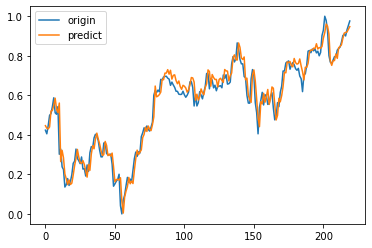

In [49]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['origin','predict'])
plt.show()

In [50]:
import visdom

In [54]:
vis = visdom.Visdom()

Setting up a new session...


In [56]:
vis.text("지후야 좀만 기다려줘!", env = "main")

'window_39d4ea520eae66'

In [ ]:
vis.text("지후야 좀만 기다려줘!", env = "main")